In [2]:
from astropy.io import fits
import clevar
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match_metrics.distances import ClCatalogFuncs as d_cf
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf
import clevar.match_metrics.scaling as scaling

import pandas as pd
from astropy.table import Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [5]:
hdul_halos = fits.open("../halos/halos.fits")
hdul_amico = fits.open("JPAS_mock_cut_map_detections_refined_amico.fits")

table_halos = hdul_halos[1].data
table_amico = hdul_amico[1].data

logMmin = 12.0
logMmax = 15


table_amico.columns['Xphys'].name = 'RA'
table_amico.columns['Yphys'].name = 'DEC'
table_amico.columns['Zphys'].name = 'z'
#print(table_amico.columns)

table_halos = table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir']
             <= 10**logMmax) & (table_halos['DEC'] <=table_amico['DEC'].max()) & (table_halos['DEC'] >= table_amico['DEC'].min())
                      &   (table_halos['RA'] <= table_amico['RA'].max()) & (table_halos['RA'] >=table_amico['RA'].min())]
table_halos['Mvir'] = table_halos['Mvir']/0.6774

print(table_halos.size)
print(table_amico.size)

print("DEC max")
print(table_amico['DEC'].max())
print(table_halos['DEC'].max())
print('\n')
print("DEC min")
print(table_amico['DEC'].min())
print(table_halos['DEC'].min())
print('\n')
print("RA max")
print(table_amico['RA'].max())
print(table_halos['RA'].max())
print('\n')
print("RA min")
print(table_amico['RA'].min())
print(table_halos['RA'].min())
print('\n')
print("z max")
print(table_amico['z'].max())
print(table_halos['redshift_R'].max())
print('\n')
print("z min")
print(table_amico['z'].min())
print(table_halos['redshift_R'].min())

158670
59100
DEC max
50.202178
50.20208740234375


DEC min
39.695278
39.695343017578125


RA max
175.79409
175.79391479492188


RA min
164.22079
164.2209014892578


z max
0.7175
0.6646281966028926


z min
0.0125
0.02198604523781358


0.69389791

## Lambdastar definition of richness ##


In [6]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_amico = clevar.ClCatalog('Detection catalog',SN=table_amico['SN'], ra=table_amico['RA'], dec=table_amico['DEC'], mass=table_amico['LAMBSTAR'],z=table_amico['z'] )

/global/u2/l/lettieri/miniforge3/envs/numcosmo_developer/lib/python3.12/site-packages/clevar-0.15.3-py3.12.egg/clevar/catalog/tagdata.py:278: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


In [7]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'redshift_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

#mt.match_from_config(catalog_halos, catalog_amico, match_config, cosmo=cosmo_astropy)
#mt.save_matches(catalog_halos, catalog_amico, out_dir='temp_lambstar', overwrite=True)

In [8]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_amico = clevar.ClCatalog('Detection catalog',SN=table_amico['SN'], ra=table_amico['RA'], dec=table_amico['DEC'], mass=table_amico['LAMBSTAR'],z=table_amico['z'] )
mt = clevar.match.ProximityMatch()
mt.load_matches(catalog_halos, catalog_amico, out_dir='temp_lambstar')

halos_match, detections_match = clevar.match.get_matched_pairs(catalog_halos, catalog_amico, 'cross')

Halo catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    158,670
 * multiple (self):  101,034
 * multiple (other): 101,034
 * unique (self):    47,166
 * unique (other):   47,164
 * cross:            46,943

Detection catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    59,100
 * multiple (self):  50,351
 * multiple (other): 50,351
 * unique (self):    47,164
 * unique (other):   47,166
 * cross:            46,943


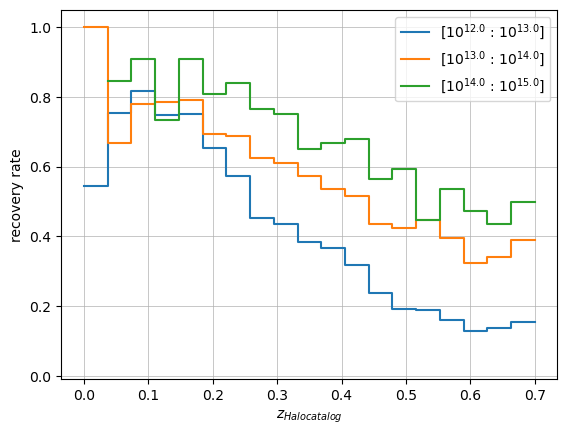

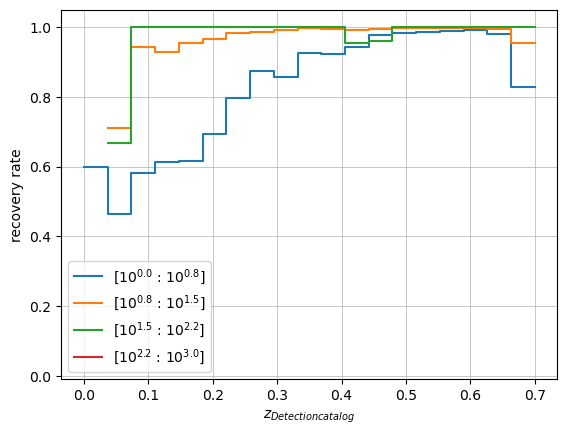

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


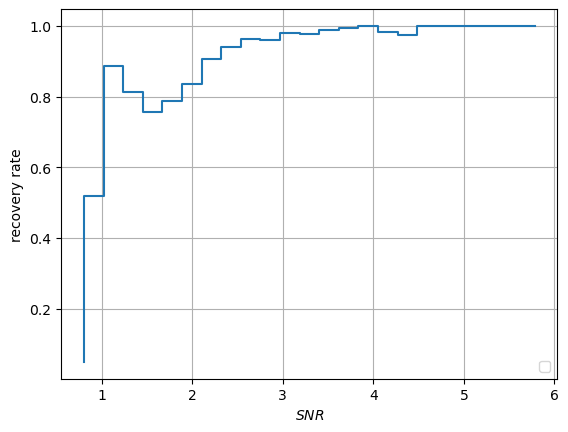

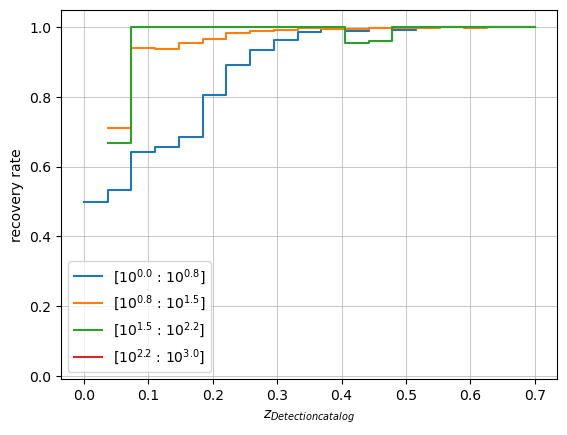

In [23]:
from clevar.match_metrics import recovery

zbins = np.linspace(0, 0.7, 20)
mbins = np.logspace(logMmin, logMmax, 4)
rbins = np.logspace(0 , 3 , 5)
info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')
plt.savefig("recovery_halos.jpg")
plt.show()

info = recovery.plot(catalog_amico, 'cross', zbins, rbins, shape='steps')
plt.savefig("recovery_detections.jpg")
plt.show()


import math
#detections_match_large['SN'].sort()
#table_ame_large['SNR'].sort()

snr = np.linspace(table_amico['SN'].min(), table_amico['SN'].max(), 25)     

recovery_snr = []
snr_plot   = []
for i in range(len(snr)-1):
    n_recovered  = 0
    n_detections = 0
    for j in range(len(detections_match["SN"])):
        if  detections_match["SN"][j] >=snr[i] and detections_match["SN"][j] <=snr[i+1]:
            n_recovered +=1
            
    for j in range(len(table_amico["SN"])):
        if  table_amico["SN"][j] >=snr[i] and table_amico["SN"][j] <=snr[i+1]:
            n_detections +=1
    
    if n_recovered == 0:
        recovery_snr.append(0)
    else:
        recovery_snr.append(n_recovered/n_detections)
    snr_plot.append((snr[i] + snr[i+1])/2)            

plt.step(snr_plot , recovery_snr)

plt.legend(loc=4)
plt.xlabel(r"$SNR$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_snr.jpg")
plt.show()

catalog_amico_2 = catalog_amico[catalog_amico['SN'] >= 2]
info = recovery.plot(catalog_amico_2, 'cross', zbins, rbins, shape='steps')
plt.savefig("recovery_detections_sn.jpg")
plt.show()

## Lambda definition of richness ##

In [8]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_amico = clevar.ClCatalog('Detection catalog',SN=table_amico['SN'], ra=table_amico['RA'], dec=table_amico['DEC'], mass=table_amico['LAMB'],z=table_amico['z'] )

/global/u2/l/lettieri/miniforge3/envs/numcosmo_developer/lib/python3.12/site-packages/clevar-0.15.3-py3.12.egg/clevar/catalog/tagdata.py:278: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


In [ ]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'redshift_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

mt.match_from_config(catalog_halos, catalog_amico, match_config, cosmo=cosmo_astropy)
mt.save_matches(catalog_halos, catalog_amico, out_dir='temp_lamb', overwrite=True)

(array([  49.,  272.,  483.,  816.,  699.,  792.,  924., 1006., 1084.,
        1480., 1180., 1169., 1364., 1006.,  943.,  960.,  765.,  875.,
         831.,  540.,  422.,  458.,  269.,  166.,   64.]),
 array([0.0175    , 0.0441    , 0.0707    , 0.0973    , 0.1239    ,
        0.1505    , 0.1771    , 0.20370001, 0.23029999, 0.25690001,
        0.28350002, 0.31009999, 0.33669999, 0.3633    , 0.3899    ,
        0.4165    , 0.44310001, 0.46970001, 0.49630001, 0.52289999,
        0.54949999, 0.57609999, 0.6027    , 0.6293    , 0.6559    ,
        0.6825    ]),
 <BarContainer object of 25 artists>)

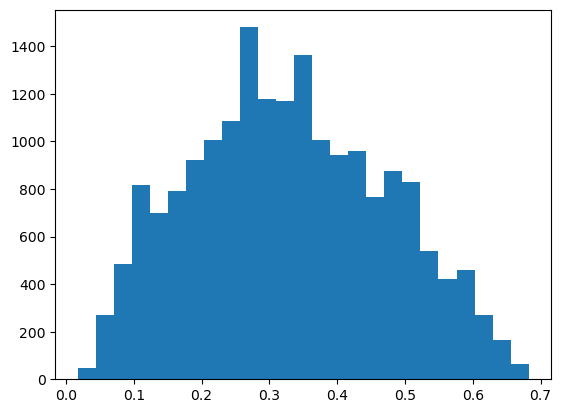

In [22]:
plt.hist(catalog_amico_2['z'],bins = 25)